<a href="https://colab.research.google.com/github/AbeTetsuyaR/AbePPO/blob/main/AbePPO0904_without_ohe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import time
import cProfile
import sys
import copy
from torch.distributions.categorical import Categorical
import math
import os
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from tqdm import tqdm  # tqdmをインポート
import matplotlib.pyplot as plt

from scipy.stats import gamma, uniform, truncnorm
import math

In [2]:
class Environment:
    def __init__(self, n_units=2):
        self.n_units = n_units #number of unit
        #self.n_states = 5 #number of state
        self.inventory = 0
        self.demand = 0
        self.maintenance_status = [0] * self.n_units
        self.interval = 24
        self.remain_interval = 24
        self.MAX_speed = 10/self.interval
        self.MAX_inventory = 0
        self.MAX_demand = 15
        self.MAX_maintenance_time = 0

        self.load_total=1

        self.cp = 500#
        self.cc = 1800#

        self.cps = 0
        self.co = 5
        self.cs = 500#

        self.levels = [0] * self.n_units
        self.shape = 3
        self.penalty = 1
        self.L = 100#
        #self.P_Cost =[[100,110,130,160,2540],
                      #[110,120,140,170,2550],
                      #[130,140,160,190,2570],
                      #[160,170,190,220,2600],
                      #[2540,2550,2570,2600,5000]]#convex化

        self.P_Cost =[[0,0,0,0,2500],
                      [0,0,0,0,2500],
                      [0,0,0,0,2500],
                      [0,0,0,0,2500],
                      [2500,2500,2500,2500,5000]]#平滑化
        self.P_Cost_L = 2500

        self.Visit =[[0,0,0,0,0],
                      [0,0,0,0,0],
                      [0,0,0,0,0],
                      [0,0,0,0,0],
                      [0,0,0,0,0]]
        self.cntCount=[0,0]

        self.failure_keep1 = 0 #1つ故障しているのに保全を選択しなかった回数
        self.failure_keep2 = 0 #2つ故障しているのに保全を選択しなかった回数
        self.failure_keep3 = 0 #3つ故障しているのに保全を選択しなかった回数
        self.replace_chance = 0 #保全を選択できた回数

    def init_random(self):
        levels=[0,0]
        self.load_total=1
        return levels, self.load_total



    def reset(self):
        self.levels = np.zeros(self.n_units)

    def complete_maintenance(self, unit_idx):
        self.levels[unit_idx] = 0

    def get_ability(self, level): #良品率
        if level == 0:
            return 1
        elif level == 1:
            return 0.8
        elif level ==2:
            return 0.5
        elif level == 3:
            return 0.1
        return (self.n_states - 1 - level) / (self.n_states - 1)

    def update_demand(self, speed, ability, time):
        if self.demand >= self.inventory:
            self.demand -= self.inventory
            self.inventory = 0.0
        else:
            self.inventory -= self.demand
            self.demand = 0.0
        return max(0, self.demand-self.inventory-ability*speed*time)

    def update_inventory(self, speed, ability, time):
        if self.demand <= self.inventory + ability * speed * time:
            return min(self.MAX_inventory, -self.demand+self.inventory+ability*speed*time), max(0, -self.MAX_inventory-self.demand+self.inventory+ability*speed*time)
        else:
            return 0.0, 0.0

    def get_maintenance_time(self,level):
        return 0

    def update_maintenance_time(self, unit_idx):
        return 0

    def one_hot_encode(self):
        level_ohe = []
        #mstatus_ohe = []
        for unit_idx in range(self.n_units):
            l = [0] * self.n_states
            #m = [0] * (self.MAX_maintenance_time + 1)
            l[min(math.floor(self.levels[unit_idx]),self.n_states-1)] = 1
            #m[self.maintenance_status[unit_idx]] = 1
            level_ohe = level_ohe + l
            #mstatus_ohe = mstatus_ohe + m
        return level_ohe #mstatus_oheは削除



    def operation(self, replacements, load_rate):
        reward = 0
        #print(load_rate)

        flag = 0

        #保全の意思決定
        #print(replacements)

        if replacements==[1,1]: #稼働継続

          #reward -= self.P_Cost[min(math.floor(self.levels[0]),self.n_states-1)][min(math.floor(self.levels[1]),self.n_states-1)] #rewardを最初に計算
          if self.levels[0]>self.L:
            reward -= self.P_Cost_L
          if self.levels[1]>self.L:
            reward -= self.P_Cost_L
          #print(reward)
          # パラメータの設定
          scales=[0,0]
          shape0 = 0.69  # ガンマ分布のパラメータ v1 用 0.69 100倍にしてみる
          shape1 = 0.69   # ガンマ分布のパラメータ v2 用
          tau = 0.5  # ケンドールの順位相関係数

          theta = 1 / (1 - tau)

          #if load_rate<0:##
            #load_rate=0
          #if load_rate>1:
            #load_rate=1
          loads=[0,0]
          loads[0]=load_total*load_rate
          loads[1]=load_total*(1-load_rate)

          #print(speeds, "speeds")
          #尺度パラメータ計算
          for i in range(self.n_units):
            scales[i]=6.491*(loads[i]**2)+0.726
            #scales[i]=6.491*(speeds[i]**0.5)+0.726
            #scales[i]=scales[i] #1/10000倍にしてみる


          # 一様分布から独立にサンプリング
          u = uniform.rvs(size=1)
          v = uniform.rvs(size=1)
          #print("u,v:",u,v)
          # ガンベルコピュラの逆関数を適用
          x = (-np.log(u)) ** theta
          y = (-np.log(v)) ** theta
          #print("x,y:",x,y)

          t = (x + y) ** (1/theta)
          #print("t:",t)

          u_new = np.exp(-t * (x / (x + y)))
          v_new = np.exp(-t * (y / (x + y)))

          # ガンマ分布に変換
          v1 = gamma.ppf(u_new, shape0, scale=scales[0])
          v2 = gamma.ppf(v_new, shape1, scale=scales[1])
          #print(v1,v2)
          #v1 = gamma.rvs(shape0, scale=scales[0])
          #v2 = gamma.rvs(shape1, scale=scales[1])

          #print("稼働継続")
          #print(v1,v2, "劣化増分")
          self.levels[0]+=v1
          self.levels[1]+=v2
          #print(self.levels, "劣化")


        elif replacements==[0,1]: #1のみ取替
          reward -= self.cs
          if self.levels[0]<self.L:
            reward -= self.cp
          else:
            reward -= self.cc
          self.levels[0]=0

        elif replacements==[1,0]: #2のみ取替
          reward -= self.cs
          if self.levels[1]<self.L:
            reward -= self.cp
          else:
            reward -= self.cc
          self.levels[1]=0
        else: #両方取替
          reward -= self.cs
          if self.levels[0]<self.L:
            reward -= self.cp
          else:
            reward -= self.cc
          if self.levels[1]<self.L:
            reward -= self.cp
          else:
            reward -= self.cc
          self.levels=[0,0]

        #print(self.levels)
        #print(reward)

        #level_ohe= self.one_hot_encode()

        #print(f'状態:{self.levels}, 保全状態:{self.maintenance_status}, 在庫:{self.inventory}, 需要:{self.demand}, 残り時間:{self.remain_interval}, 保全行動:{replacements}, {speeds}')
        #print("#############")

        flag = 0

        #切断正規分布
        dist_N = truncnorm(0, 2, loc=1, scale=1)
        self.load_total=float(dist_N.rvs(1))
        #print(self.load_total)

        #self.Visit[min(math.floor(self.levels[0]),self.n_states-1)][min(math.floor(self.levels[1]),self.n_states-1)] += 1

        return reward, levels, self.load_total
        #return reward, level_ohe, mstatus_ohe, \
        #       0, (self.demand-mean)/variance, self.remain_interval * 2 / self.interval - 1, flag


    #劣化レベル順にすべき可能性

In [3]:
class PPOMemory:
    def __init__(self,batch_size, interval, beta, GAE_lam):
        self.states = []
        self.probs_dsc = []
        self.probs_cnt = []
        self.vals = []
        self.acts_dsc = []
        self.acts_cnt = []
        self.rewards = []
        self.time = []
        self.batch_size = batch_size
        self.interval = interval
        self.beta = beta
        self.advantage = []
        self.lam = GAE_lam



    def generate_advantage(self):
        advantage = []
        adv = 0
        #gamma = math.exp(-self.beta)
        #lambd = 0.0
        beta=0.99
        for t in reversed(range(len(self.rewards))):
            if t == len(self.rewards) - 1:
                adv = self.rewards[t] - self.vals[t]
            else:
                adv = self.rewards[t] + beta * self.vals[t+1] - self.vals[t]
            #gae = delta + lambd * gamma * gae  # Assuming lambda = 1 for simplicity, otherwise use gamma * lambda * gae
            advantage.insert(0, adv)
        self.advantage = np.array(advantage, dtype=np.float32)


    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
               np.array(self.acts_dsc),\
               np.array(self.acts_cnt),\
               np.array(self.probs_dsc),\
               np.array(self.probs_cnt),\
               np.array(self.vals),\
               np.array(self.rewards),\
               np.array(self.advantage),\
               batches



    def store_memory(self, state, act_dsc, act_cnt, probs_dsc, probs_cnt, vals, reward, time):
        self.states.append(state)
        self.acts_dsc.append(act_dsc)
        self.acts_cnt.append(act_cnt)
        self.probs_dsc.append(probs_dsc)
        self.probs_cnt.append(probs_cnt)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.time.append(time)

    def clear_memory(self):
        self.states = []
        self.probs_dsc = []
        self.probs_cnt = []
        self.acts_dsc = []
        self.acts_cnt = []
        self.rewards = []
        self.vals = []
        self.time = []

"""
    def generate_advantage(self):
        advantage = []
        gae = 0
        gamma = math.exp(-self.beta)
        lambd = 0.0
        for t in reversed(range(len(self.rewards))):
            if t == len(self.rewards) - 1:
                delta = self.rewards[t] - self.vals[t]
            else:
                delta = self.rewards[t] + gamma * self.vals[t+1] - self.vals[t]
            gae = delta + lambd * gamma * gae  # Assuming lambda = 1 for simplicity, otherwise use gamma * lambda * gae
            advantage.insert(0, gae)
        self.advantage = np.array(advantage, dtype=np.float32)

    def generate_advantage(self):

        advantage = []
        gae = 0
        for t in reversed(range(len(self.rewards))):
            gamma = 1
            if t == len(self.rewards) - 1:
                delta = self.rewards[t] - self.vals[t]
            else:
                gamma = math.exp(-self.beta*1) #修正
                delta = self.rewards[t] + gamma * self.vals[t+1] - self.vals[t]
            gae = delta + gamma * gamma * gae
            advantage.insert(0, gae)
        self.advantage = np.array(advantage,dtype=np.float32)
"""

'\n    def generate_advantage(self):\n        advantage = []\n        gae = 0\n        gamma = math.exp(-self.beta)\n        lambd = 0.0\n        for t in reversed(range(len(self.rewards))):\n            if t == len(self.rewards) - 1:\n                delta = self.rewards[t] - self.vals[t]\n            else:\n                delta = self.rewards[t] + gamma * self.vals[t+1] - self.vals[t]\n            gae = delta + lambd * gamma * gae  # Assuming lambda = 1 for simplicity, otherwise use gamma * lambda * gae\n            advantage.insert(0, gae)\n        self.advantage = np.array(advantage, dtype=np.float32)\n\n    def generate_advantage(self):\n\n        advantage = []\n        gae = 0\n        for t in reversed(range(len(self.rewards))):\n            gamma = 1\n            if t == len(self.rewards) - 1:\n                delta = self.rewards[t] - self.vals[t]\n            else:\n                gamma = math.exp(-self.beta*1) #修正\n                delta = self.rewards[t] + gamma * self.va

In [4]:
class ActorNetwork(nn.Module):
    def __init__(self, n_units, n_states, MAX_maintenance_time, input_dims, alpha, fc1_dims=64, fc2_dims=64, fc3_dims=64, chkpt_dir=""):
        super(ActorNetwork, self).__init__()
        self.n_units = n_units
        self.n_states = n_states
        self.MAX_maintenance_time = MAX_maintenance_time
        self.checkpoint_file = os.path.join(chkpt_dir, "actor_torch_ppo")


        self.fc1 = nn.Linear(input_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.fc3 = nn.Linear(fc1_dims, fc3_dims)

        self.dsc = nn.Linear(fc2_dims, 2 ** n_units) #離散行動
        # 以下に初期化コードを追加
        self.init_dsc_weights()

        self.softmax = nn.Softmax(dim=-1)
        self.Tanh = nn.Tanh()

        self.mean = nn.Linear(fc3_dims, n_units-1)
        self.log_std = nn.Linear(fc3_dims, n_units-1)

        # mean レイヤーの初期化
        #self.init_mean_weights()
        # std レイヤーの初期化
        #self.init_std_weights()

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)

        #0824 optimizer追加
        self.optimizer_discrete = optim.Adam([
            {'params':self.fc1.parameters()},
            {'params':self.fc2.parameters()},
            {'params':self.dsc.parameters()},
        ], lr=alpha)

        self.optimizer_continuous = optim.Adam([
            {'params':self.fc1.parameters()},
            {'params':self.fc3.parameters()},
            {'params':self.mean.parameters()},
            {'params':self.log_std.parameters()},
        ], lr=alpha)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

        self.scheduler_actor = optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.95)

    def init_dsc_weights(self):
        # ここで特定の出力確率を設定するための重みとバイアスを設定
        with torch.no_grad():
            # すべての出力がほぼ等しくなるように設定
            self.dsc.weight.fill_(0.0)
            # 特定の確率分布に調整
            self.dsc.bias.data = torch.log(torch.tensor([0.004, 0.003, 0.003, 0.99]))  # logを取るのがポイント

    def init_mean_weights(self):
        # mean レイヤーの初期化
        with torch.no_grad():
            self.mean.weight.fill_(0.0)
            self.mean.bias.fill_(0.0)  # ここで固定出力0.5を設定#0に変更

    def init_std_weights(self):
        # std レイヤーの初期化
        with torch.no_grad():
            self.log_std.weight.fill_(0.0)
            self.log_std.bias.fill_(1.0)  # ここで固定出力0.7を設定

    #離散行動空間を制限するための関数, 返り値はmaskで制限されるところは-inf,されないところは1。返り値はバッチ数*2
    def create_dsc_mask(self, state): #state=[s,m,b,d,t], action=[P(replace), P(keep)]
        mask = torch.zeros(state.size(0),2**self.n_units)
        #保全を選択できる時点にて、保全中のユニットは保全を選択できない
        for unit_idx in range(self.n_units):
            for a in range(2 ** self.n_units):
                action_list = [int(bit) for bit in format(a, f'0{self.n_units}b')] #action_list=[r1,r2,r3,...]

                #エラーのため省略
                #if action_list[unit_idx] == 0:
                    #保全の意思決定時点のとき、保全中の場合は保全を選択できない
                    #保全の意思決定時点でないとき、保全を選択できない
                    #mask[(state[:,(self.n_states*self.n_units-1+(self.MAX_maintenance_time+1)*unit_idx+1)] == 0)\
                        #, a] = torch.tensor(1)


        mask[(state[:, 4] == 1) & (state[:, 9] == 1) & \
             (state[:,self.n_states*self.n_units-1 + 1] == 1)
            ,1:] = torch.tensor(1) #2 ** self.n_units-1
            #状態とユニット数により要変更

        return mask.bool()

    def create_cnt_mask(self, state):
        mask= torch.zeros(state.size(0), self.n_units)
        for unit_idx in range(self.n_units):
            a = 2**(self.n_units)-1 - 2**(self.n_units-1-unit_idx)

            #エラーのため省略
            #保全の意思決定ができる時
            mask[(state[:,-1] == 1) & \
                 ((dist_dsc[:,a] <= 0.0001) |
                  (state[:,unit_idx*self.n_states+self.n_states-1] == 1) | \
                  (state[:,(self.n_states*self.n_units-1+(self.MAX_maintenance_time+1)*unit_idx+1)] == 0)), unit_idx] = torch.tensor(1)
            mask[((state[:,unit_idx*self.n_states+self.n_states-1] == 1) | \
                  (state[:,(self.n_states*self.n_units-1+(self.MAX_maintenance_time+1)*unit_idx+1)] == 0)), unit_idx] = torch.tensor(1)


        return mask.bool()



    def forward(self, state):
        #print(state[0,-1].item())
        x = F.relu(self.fc1(state))
        x2 = F.relu(self.fc2(x))
        x3 = F.relu(self.fc3(x))

        #first_mask = self.create_dsc_mask(state)

        #離散行動の分布
        dist_dsc = self.dsc(x2)
        #dist_dsc = dist_dsc.masked_fill(first_mask,-1e5)

        dist_dsc = self.softmax(dist_dsc)
        #if (state[0,4]==1 and state[0,9]==1 and state[0,14]==1 and state[0,15]==1 and state[0,19]==1 and state[0,23]==1 and state[0,-1]==1):
        #print(state)
        #    print(dist_dsc)
        #    print("&&&&&&&&")


        #second_mask = self.create_cnt_mask(state)
        dist_dsc = Categorical(dist_dsc)

        #連続行動の分布
        mean = self.mean(x3)
        #mean = self.softmax(mean)
        #mean = self.Tanh(mean)/2+0.5#[0,1]に補正
        mean = self.Tanh(mean)

        #load_max=min(state[0,-1].item(),1) #operationへ移動
        #load_min=max(state[0,-1].item() -1,0)
        #mean=load_min + (load_max-load_min)*mean

        #mean = mean.masked_fill(second_mask, -1) #セカンドマスク

        #print(dist_dsc, mean)
        #print(state)
        #print(dist_dsc)
        #mean = torch.clamp(mean,min=-5,max=5)
        log_std = self.log_std(x3)
        log_std = torch.clamp(log_std,min=-20,max=2)
        std = log_std.exp()
        #std = std.masked_fill(second_mask, 1e-4) #セカンドマスク
        #print(mean)
        #print("AAAA")

        #print(mean,std)

        #dist_cnt = torch.distributions.MultivariateNormal(loc=mean, covariance_matrix = torch.stack([torch.diag(x**2+1e-10) for x in std]))
        #mean=state[0,-1].item()/2#試験

        variance = std ** 2
        #print(variance)
        #if variance > mean*(1-mean)/2:#補正
            #variance = mean*(1-mean)/2
        variance = torch.min(variance, mean*(1-mean)/2)

        # alpha と beta の計算式を安全に実施
        epsilon = 1e-6  # ゼロ除算を防ぐための小さな値
        mean_clamped = mean.clamp(min=epsilon, max=1-epsilon)  # mean を [epsilon, 1-epsilon] でクランプ
        variance_clamped = variance.clamp(min=epsilon)  # variance を epsilon 以上でクランプ

        alpha = ((1 - mean_clamped) / variance_clamped - 1 / mean_clamped) * (mean_clamped ** 2)
        beta = alpha * (1 / mean_clamped - 1)
        #print("After:", mean)
        # これらの値が正であることを保証
        alpha = torch.max(alpha, torch.tensor(epsilon))
        beta = torch.max(beta, torch.tensor(epsilon))

        dist_cnt = torch.distributions.Normal(loc=mean, scale=std) #1次元化のため
        #dist_cnt = torch.distributions.Beta(alpha, beta) #ベータ分布にしてみる
        #print(state[0,-1].item(),mean)


        return dist_dsc, dist_cnt

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))

In [5]:
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=32, fc2_dims=32, fc3_dims=64, chkpt_dir=""):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, "critic_torch_ppo")
        self.critic = nn.Sequential(
            nn.Linear(input_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims,fc2_dims),
            nn.ReLU(),
            #nn.Linear(fc2_dims,fc3_dims),
            #nn.ReLU(),
            nn.Linear(fc2_dims,1)
        )
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

        self.scheduler_critic = optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.95)

        # 重みの初期化
        #self.init_weights()

    def init_weights(self):
        for layer in self.critic:
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)  # Xavier初期化を適用
                torch.nn.init.constant_(layer.bias, 18000)  # バイアスを14000で初期化

    def forward(self, state):
        value = self.critic(state)
        return value

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))

In [6]:
os.getcwd()

'/content'

In [7]:
test_batch = 0
class Agent:
    def __init__(self, n_units, n_states, MAX_maintenance_time, input_dims, beta=0.0005, GAE_lam=0.00, interval=24,
                 alpha_actor=0.03, alpha_critic=0.01,
                 policy_clip=0.2, batch_size=512*4, n_epochs=4):
        self.beta = beta
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs

        self.loss_history = []
        self.loss_history_detail = []

        self.actor_loss_history = []
        self.actor_loss_history_detail = []
        self.critic_loss_history = []
        self.critic_loss_history_detail = []
        self.entropy_history = []
        self.kl_divergence_history = []

        self.actor = ActorNetwork(n_units, n_states, MAX_maintenance_time, input_dims, alpha_actor)
        self.critic = CriticNetwork(input_dims, alpha_critic)
        self.memory = PPOMemory(batch_size, interval=interval, beta=beta, GAE_lam=GAE_lam)

    def remember(self,state,action_dsc,action_cnt,probs_dsc,probs_cnt,vals,reward, time):
        self.memory.store_memory(state,action_dsc,action_cnt,probs_dsc,probs_cnt,vals,reward, time)

    def save_models(self):
        print("... saving models ...")
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print("... loading models ...")
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self,observation):
        state = torch.tensor(np.array([observation]),dtype=torch.float).to(self.actor.device)
        dist_dsc, dist_cnt = self.actor(state)

        state_rev = state.clone()
        state_rev[:, [0, 1]] = state_rev[:, [1, 0]]
        value = (self.critic(state)+self.critic(state_rev))/2#0907

        act_dsc = dist_dsc.sample()
        act_cnt = dist_cnt.sample()

        log_prob_dsc = torch.squeeze(dist_dsc.log_prob(act_dsc)).item()

        if act_dsc.item() == 3:
          log_prob_cnt = torch.squeeze(dist_cnt.log_prob(act_cnt)).item()
          #print(log_prob_cnt, "log_prob_cnt")
        else:
          #log_prob_cnt = 0 #dist_cntを参照しないことの補正
          log_prob_cnt = torch.squeeze(dist_cnt.log_prob(act_cnt)).item()


        log_prob = log_prob_dsc + log_prob_cnt

        value = torch.squeeze(value).item()

        return act_dsc, act_cnt, log_prob_dsc, log_prob_cnt, value

    def choose_action_max_prob(self,observation):
        state = torch.tensor(np.array([observation]),dtype=torch.float).to(self.actor.device)
        dist_dsc, dist_cnt = self.actor(state)
        print("state:", state, "dist_dsc.probs:", dist_dsc.probs, "dist_cnt.mean:",dist_cnt.mean,"dist_cnt.scale", dist_cnt.scale)
        act_dsc = torch.argmax(dist_dsc.probs)
        act_cnt = dist_cnt.mean
        #print(act_dsc, ":act_dsc")
        #print(act_cnt, ":act_cnt")

        value = self.critic(state)


        log_prob_dsc = torch.squeeze(dist_dsc.log_prob(act_dsc)).item()
        log_prob_cnt = torch.squeeze(dist_cnt.log_prob(act_cnt)).item()
        log_prob = log_prob_dsc + log_prob_cnt

        value = torch.squeeze(value).item()

        return act_dsc, act_cnt, log_prob_dsc, log_prob_cnt, value

    def learn(self,episode, threshold):
        self.memory.generate_advantage()
        actor_loss_sum = 0
        critic_loss_sum = 0
        entropy_sum = 0
        kl_divergence_sum = 0
        for _ in range(self.n_epochs):
        #for _ in tqdm(range(self.n_epochs), desc="Training Progress"):  # tqdmを用いて進捗表示
            """
            rewards = self.memory.rewards
            values = self.memory.vals
            times = self.memory.time
            advantage = np.zeros(len(reward_arr),dtype=np.float32)
            for t in range(len(reward_arr)-1):
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += math.exp(-self.beta * times[k]) * \
                        (reward_arr[k]+math.exp(-self.beta * (-times[k]%self.interval+self.interval))*values[k+1]-values[k])
                advantage[t] = a_t
            advantage = torch.tensor(advantage).to(self.actor.device)
            """
            state_arr, act_dsc_arr, act_cnt_arr, old_probs_dsc_arr, old_probs_cnt_arr, vals_arr, reward_arr, advantage, batches=self.memory.generate_batches()
            values = vals_arr
            """
            values = vals_arr
            times = time_arr
            advantage = np.zeros(len(reward_arr),dtype=np.float32)
            for t in range(len(reward_arr)-1):
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += math.exp(-self.beta * times[k]) * (reward_arr[k]+self.gamma*values[k+1]-values[k])
                advantage[t] = a_t
            """
            advantage = torch.tensor(advantage).to(self.actor.device)

            values = torch.tensor(values).to(self.actor.device)
            start = time.time()
            for batch in batches:  # 各バッチの進捗を表示
                states = torch.tensor(state_arr[batch], dtype=torch.float).to(self.actor.device)
                log_old_probs_dsc = torch.tensor(old_probs_dsc_arr[batch]).to(self.actor.device)
                log_old_probs_cnt = torch.tensor(old_probs_cnt_arr[batch]).to(self.actor.device)
                acts_dsc = torch.tensor(act_dsc_arr[batch]).to(self.actor.device)
                acts_cnt = torch.tensor(act_cnt_arr[batch]).to(self.actor.device)

                dist_dsc, dist_cnt = self.actor(states)

                critic_value = self.critic(states)#0907
                critic_value = torch.squeeze(critic_value)

                log_new_probs_dsc = dist_dsc.log_prob(acts_dsc) #pi_new
                log_new_probs_cnt = dist_cnt.log_prob(acts_cnt)

                #log_new_probs = dist_dsc.log_prob(acts_dsc) + dist_cnt.log_prob(acts_cnt)
                #print("log_old_probs_cnt.exp():",log_old_probs_cnt.exp())
                #print("log_new_probs_cnt.exp():",log_new_probs_cnt.exp())
                #print("log_old_probs_cnt:",log_old_probs_cnt)
                #print("log_new_probs_cnt",log_new_probs_cnt)

                prob_ratio_dsc = log_new_probs_dsc.exp()/log_old_probs_dsc.exp() #確率比
                prob_ratio_cnt = log_new_probs_cnt.exp()/log_old_probs_cnt.exp()
                #print("prob_ratio_dsc:",prob_ratio_dsc)
                #print("prob_ratio_cnt:",prob_ratio_cnt)


                weighted_probs_dsc = advantage[batch]*prob_ratio_dsc
                weighted_clipped_probs_dsc = torch.clamp(prob_ratio_dsc, 1-self.policy_clip, 1+self.policy_clip)*advantage[batch]
                actor_loss_dsc = -torch.min(weighted_probs_dsc, weighted_clipped_probs_dsc).mean()

                weighted_probs_cnt = advantage[batch]*prob_ratio_cnt
                weighted_clipped_probs_cnt = torch.clamp(prob_ratio_cnt, 1-self.policy_clip, 1+self.policy_clip)*advantage[batch]
                actor_loss_cnt = -torch.min(weighted_probs_cnt, weighted_clipped_probs_cnt).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = F.mse_loss(returns.float(),critic_value.float())
                #critic_loss = critic_loss.float()
                #print(actor_loss)
                #print(critic_loss)
                #print("#####")
                entropy_dsc = dist_dsc.entropy().sum(dim=0).mean()
                entropy_cnt = dist_cnt.entropy().sum(dim=0).mean()
                entropy = torch.clamp(entropy_dsc,min=0) + torch.clamp(entropy_cnt,min=0)
                #entropy = torch.clamp(dist_dsc.entropy().mean(),min=0) + torch.clamp(dist_cnt.entropy().mean(), min=0.0)

                total_loss_dsc = actor_loss_dsc #+ 0.01 * entoropy_dsc
                total_loss_cnt = actor_loss_cnt #+ 0.01 * entoropy_cnt
                total_loss = total_loss_dsc + total_loss_cnt + 0.5*critic_loss #+ 0.01*entropy

                if episode >= threshold:
                  print("FLAG")
                  self.actor.optimizer_discrete.zero_grad()
                  total_loss_dsc.backward(retain_graph=True)
                  self.actor.optimizer_discrete.step()

                #if episode >= threshold:
                  #print("FLAG")
                  self.actor.optimizer_continuous.zero_grad()
                  total_loss_cnt.backward(retain_graph=True)
                  self.actor.optimizer_continuous.step()

                self.critic.optimizer.zero_grad()
                critic_loss.backward()
                self.critic.optimizer.step()

                self.loss_history_detail.append(total_loss.item())

                actor_loss_sum += actor_loss_dsc.item()+actor_loss_cnt.item()
                critic_loss_sum += critic_loss.item()
                entropy_sum += entropy.item()
                kl_divergence_sum += torch.distributions.kl_divergence(Categorical(logits=log_old_probs_dsc+log_old_probs_cnt), Categorical(logits=log_new_probs_dsc+log_new_probs_cnt)).mean().item()

                print("advantage[batch].size(),advantage[batch]:",advantage[batch].size(),advantage[batch])

        print(f'actor loss: {actor_loss_sum}, critic loss: {critic_loss_sum}, entropy: {entropy_sum}, KL divergence: {kl_divergence_sum}')
        self.loss_history.append(np.mean(self.loss_history_detail[-self.n_epochs:]))
        self.actor_loss_history.append(actor_loss_sum)
        self.critic_loss_history.append(critic_loss_sum)
        self.entropy_history.append(entropy_sum)
        self.kl_divergence_history.append(kl_divergence_sum)
            # Update sums
        #self.actor.scheduler_actor.step()  # 学習率を更新
        #self.critic.scheduler_critic.step()  # 学習率を更新
        self.memory.clear_memory()

In [8]:
#エージェントの初期化
n_units = 2
n_states = 5
MAX_maintenance_time = 0
#input_size = n_units * n_states + n_units * (MAX_maintenance_time) + 2 #MDPのため[残り時間]と[保全意思決定時]の2つの入力は入れない
input_size = n_units + 1
action_size = 2**n_units  # 行動数は2^3個
batch_size = 512*4#512-5120
interval = 24
alpha_actor = 0.0003#ここを変更する
alpha_critic = 0.01#ここを変更する
n_epochs = 4
policy_clip = 0.1
beta=0.0005


agent = Agent(n_units=n_units,
              input_dims=input_size,
              n_states=n_states,
              MAX_maintenance_time=MAX_maintenance_time,
              beta=beta,
              interval=interval,
              alpha_actor=alpha_actor,
              alpha_critic=alpha_critic,
              policy_clip=policy_clip,
              batch_size=batch_size,
              n_epochs=n_epochs)
env = Environment()

In [9]:
observation0=[0,0,1]
state0 = torch.tensor(np.array([observation0]),dtype=torch.float).to(agent.actor.device)
dist_dsc0, dist_cnt0 = agent.actor(state0)
value0 = agent.critic(state0)
print("state:", state0, "dist_dsc.probs:", dist_dsc0.probs, "dist_cnt.mean:",dist_cnt0.mean,"dist_cnt.scale", dist_cnt0.scale,"value0:",value0)

state: tensor([[0., 0., 1.]]) dist_dsc.probs: tensor([[0.0040, 0.0030, 0.0030, 0.9900]], grad_fn=<DivBackward0>) dist_cnt.mean: tensor([[-0.0704]], grad_fn=<TanhBackward0>) dist_cnt.scale tensor([[1.0957]], grad_fn=<ExpBackward0>) value0: tensor([[0.2421]], grad_fn=<AddmmBackward0>)


In [10]:
num_episode =4#8*16*4で90分
threshold = 0 #cnt学習を開始するエピソード
best_reward = -np.inf
episode_reward_history = []
avg_cost = 0

for episode in range(num_episode):
    episode_reward = 0
    operation_time = 0
    one_action = 0
    two_action = 0
    three_action = 0
    penalty_action = 0
    #level_ohe, load_total = env.init_random()
    levels, load_total = env.init_random()
    if episode % 100 == 0:
        interval_time_episode = time.time()
    interval_time_episode = time.time()
    for _ in range(1024*8):#1024*8
        #state = level_ohe + list([inventory,demand])
        state = levels + list([load_total])
        #print(state)
        act_dsc, act_cnt, log_prob_dsc, log_prob_cnt, val = agent.choose_action(state)
        act_dsc_list = [int(bit) for bit in format(act_dsc.item(), f'0{env.n_units}b')]
        if sum(act_dsc_list) == 2:
            one_action += 1
        elif sum(act_dsc_list) == 1:
            two_action += 1
        elif sum(act_dsc_list) == 0:
            three_action += 1
        act_cnt_np = act_cnt.squeeze().cpu().numpy().copy()
        act_cnt_np = act_cnt_np * 0.5 + 0.5 #補正

        if act_cnt_np<0.5:
          env.cntCount[0]+=1
        else:
          env.cntCount[1]+=1
        #print(act_dsc_list,act_cnt_np)
        #reward, level_ohe_next, load_total_next= env.operation(act_dsc_list,act_cnt_np)
        reward, levels_next, load_total_next= env.operation(act_dsc_list,act_cnt_np)

        episode_reward = episode_reward *0.99 + reward
        #penalty_action += flag
        #if remain_interval > remain_interval_next:
            #operation_time += (remain_interval+1)/2*interval - (remain_interval_next+1)/2*interval
        #else:
            #operation_time += (remain_interval_next + 1) / 2 * interval
        agent.remember(state, act_dsc.item(), act_cnt.squeeze().cpu().numpy().copy(), log_prob_dsc, log_prob_cnt, val, reward, operation_time)
        levels = levels_next
        #mstatus_ohe = mstatus_ohe_next
        #inventory = inventory_next
        #demand = demand_next
        #remain_interval = remain_interval_next
        load_total = load_total_next
    #print(f'{episode}エピソード目の時間：{time.time()-interval_time_episode}')
    interval_time_episode = time.time()
    agent.learn(episode, threshold)

    old_agent = Agent(n_units=n_units,
                        input_dims=input_size,
                        n_states=n_states,
                        MAX_maintenance_time=MAX_maintenance_time,
                        beta=beta,
                        interval=interval,
                        alpha_actor=alpha_actor,
                        alpha_critic=alpha_critic,
                        policy_clip=policy_clip,
                        batch_size=batch_size,
                        n_epochs=n_epochs)
    if episode != 0:
        old_agent.load_models()

    #if Check_convergence(agent, old_agent, n_units, n_states, MAX_maintenance_time):
    #    break



    agent.save_models()
    print(f'状態{state}, 離散行動：{act_dsc_list}, 連続行動：{act_cnt_np}')
    print(f'[保全を選択できた回数,1個故障で保全を選ばない回数, 2個故障で保全を選ばない回数, 3個故障で保全を選ばない回数] = [{env.replace_chance}, {env.failure_keep1}, {env.failure_keep2}, {env.failure_keep3}]')
    env.replace_chance = 0
    env.failure_keep1 = 0
    env.failure_keep2 = 0
    env.failure_keep3 = 0
    #print(f'{episode}エピソード目の学習時間：{time.time()-interval_time_episode}')
    print(f'{episode}エピソード目の累積報酬：{episode_reward}, 一つ保全の回数：{one_action}, 二つ保全の回数：{two_action}, 三つ保全の回数：{three_action}, 違反回数：{penalty_action}')
    episode_reward_history.append(episode_reward)


<ipython-input-2-bcc7374e03e9>:221: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.load_total=float(dist_N.rvs(1))


FLAG
advantage[batch].size(),advantage[batch]: torch.Size([2048]) tensor([-4999.9580, -4999.9224, -5000.1523,  ..., -4999.9678, -5000.0713,
        -5000.1226])
FLAG
advantage[batch].size(),advantage[batch]: torch.Size([2048]) tensor([-4999.8364, -5000.1890, -4999.9365,  ..., -5000.0469, -2500.1162,
        -5000.0156])
FLAG
advantage[batch].size(),advantage[batch]: torch.Size([2048]) tensor([-4999.9448, -5000.1699, -5000.0420,  ..., -5000.0181, -5000.0713,
        -2499.9287])
FLAG
advantage[batch].size(),advantage[batch]: torch.Size([2048]) tensor([-5.0000e+03, -5.0000e+03, -5.0000e+03,  ..., -2.4999e+03,
        -4.9999e+03, -1.1444e-01])
FLAG
advantage[batch].size(),advantage[batch]: torch.Size([2048]) tensor([-4999.9790, -5000.0020, -5000.1143,  ..., -5000.0381, -5000.1040,
        -4999.9731])
FLAG
advantage[batch].size(),advantage[batch]: torch.Size([2048]) tensor([-5000.0732, -4999.9805, -5000.0815,  ..., -4999.9180, -5000.0537,
        -4999.8071])
FLAG
advantage[batch].size()

<ipython-input-4-f8c0db9f64b5>:191: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(self.checkpoint_file))
<ipython-input-5-9a2b36fae17f>:38: F

FLAG
advantage[batch].size(),advantage[batch]: torch.Size([2048]) tensor([-4.9977e+03, -2.4918e+00, -5.0039e+03,  ..., -5.0009e+03,
        -5.0046e+03, -4.9851e+03])
FLAG
advantage[batch].size(),advantage[batch]: torch.Size([2048]) tensor([-5001.8379, -4999.0005, -4996.2490,  ..., -4997.9707, -5011.1997,
        -5009.0723])
FLAG
advantage[batch].size(),advantage[batch]: torch.Size([2048]) tensor([-4997.9019, -4999.9434, -4990.7583,  ..., -5000.0068, -5001.7046,
        -5007.1328])
FLAG
advantage[batch].size(),advantage[batch]: torch.Size([2048]) tensor([-5005.6118, -4999.7368, -5013.1958,  ..., -4995.6436, -5002.1182,
            5.8450])
FLAG
advantage[batch].size(),advantage[batch]: torch.Size([2048]) tensor([-2507.5859, -5000.9829, -4995.3135,  ..., -2509.8140, -4998.2627,
        -5003.9058])
FLAG
advantage[batch].size(),advantage[batch]: torch.Size([2048]) tensor([-4989.2915, -2507.0757, -4993.5166,  ..., -5011.0293, -5004.0063,
        -4999.9604])
FLAG
advantage[batch].size()

In [11]:
os.getcwd()

'/content'

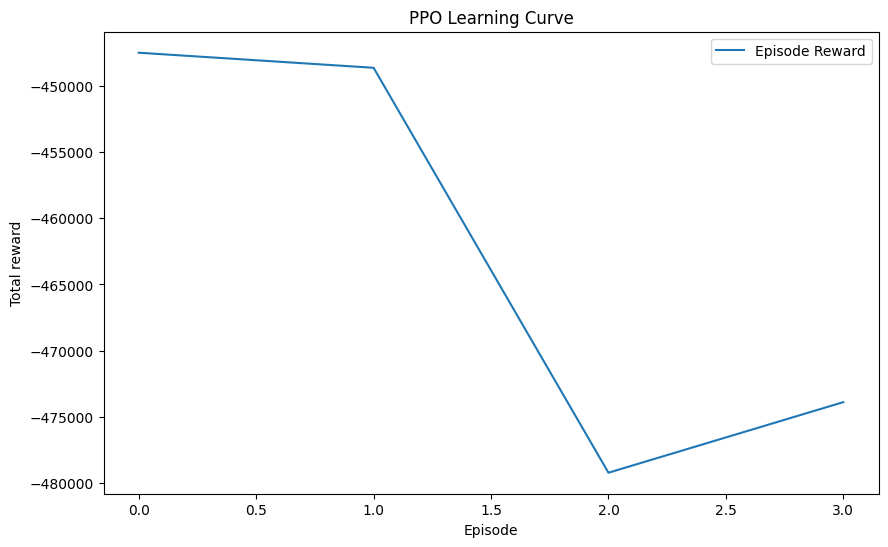

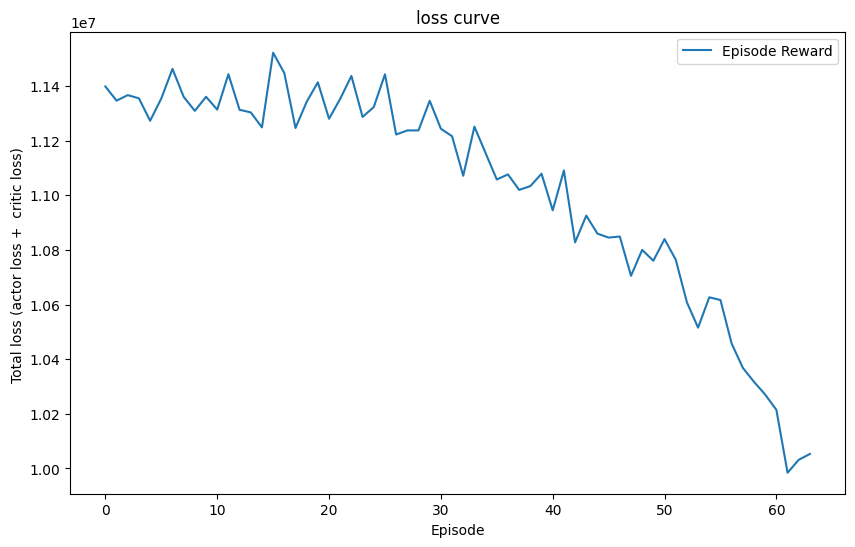

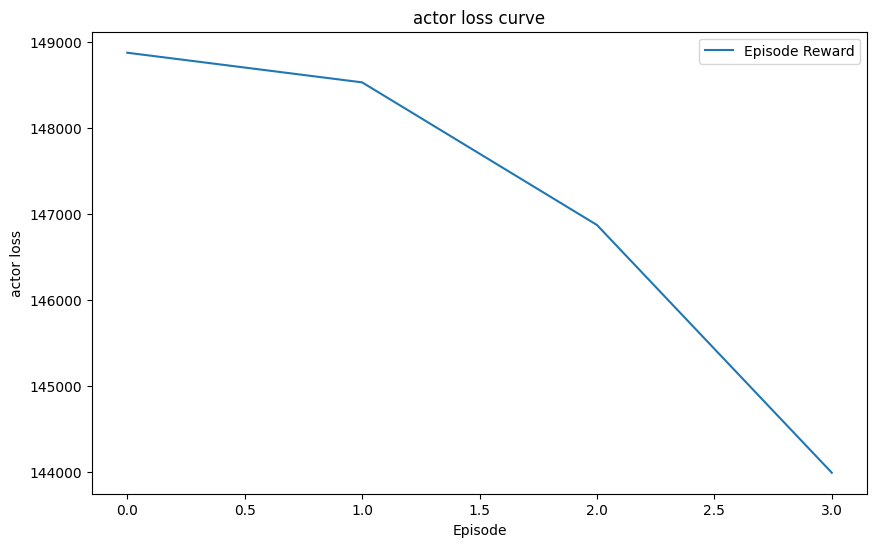

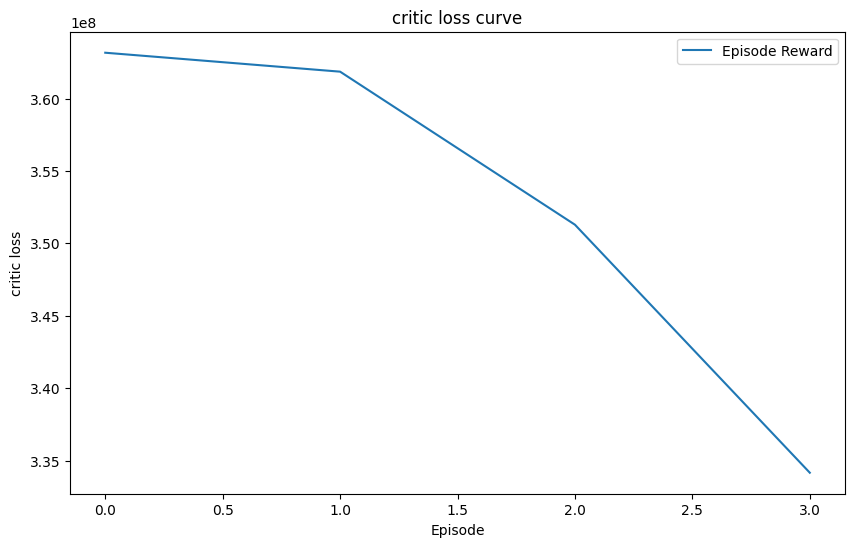

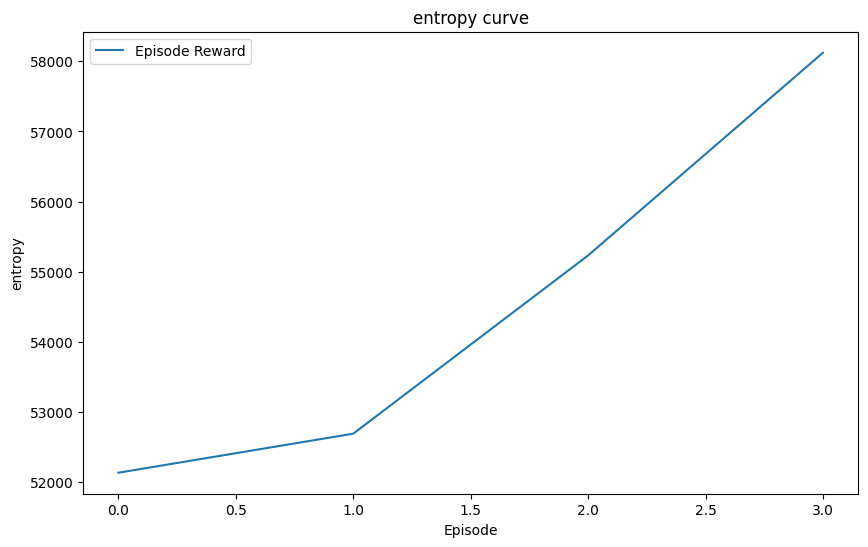

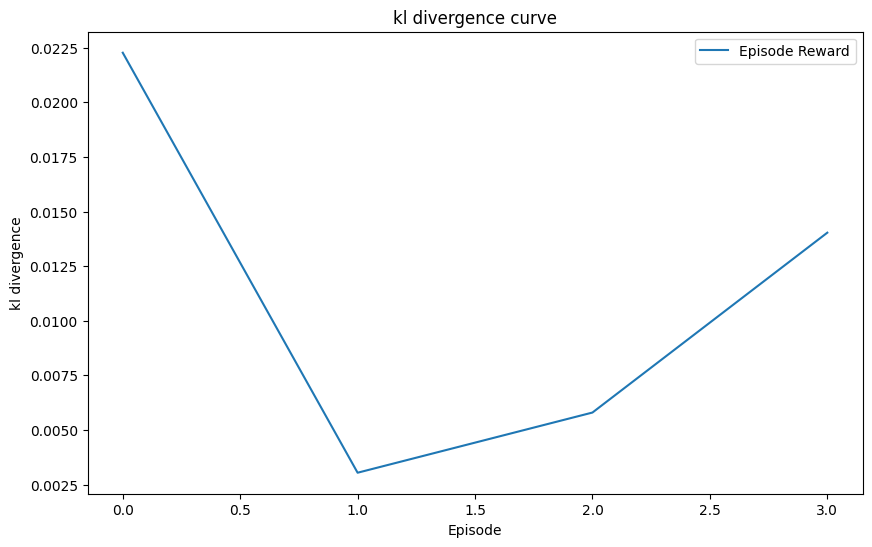

In [12]:
def plot_learning_curve(rewards, title="Learning Curve", label="Total reward"):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards, label='Episode Reward')
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel(label)
    plt.legend()
    plt.show()

# エージェントの学習
# (agent.train()の呼び出しなど)

# 学習後のエージェントの評価
#evaluate_agent(agent, env, num_episodes=10)

# 学習曲線のプロット
plot_learning_curve(episode_reward_history, title="PPO Learning Curve", label="Total reward")
plot_learning_curve(agent.loss_history_detail, title="loss curve", label="Total loss (actor loss +  critic loss) ")
plot_learning_curve(agent.actor_loss_history, title="actor loss curve", label="actor loss")
plot_learning_curve(agent.critic_loss_history, title="critic loss curve", label="critic loss")
plot_learning_curve(agent.entropy_history, title="entropy curve", label="entropy")
plot_learning_curve(agent.kl_divergence_history, title="kl divergence curve", label="kl divergence")



state: tensor([[0.0000, 0.0000, 0.2000]]) dist_dsc.probs: tensor([[0.0052, 0.0044, 0.0044, 0.9860]], grad_fn=<DivBackward0>) dist_cnt.mean: tensor([[-0.0702]], grad_fn=<TanhBackward0>) dist_cnt.scale tensor([[1.1540]], grad_fn=<ExpBackward0>)
3 -0.07017098
-0.07017098 <class 'numpy.ndarray'>
state: tensor([[ 0.0000, 10.0000,  0.2000]]) dist_dsc.probs: tensor([[0.0172, 0.0266, 0.0265, 0.9296]], grad_fn=<DivBackward0>) dist_cnt.mean: tensor([[-0.8253]], grad_fn=<TanhBackward0>) dist_cnt.scale tensor([[1.6099]], grad_fn=<ExpBackward0>)
3 -0.82534003
-0.82534003 <class 'numpy.ndarray'>
state: tensor([[ 0.0000, 20.0000,  0.2000]]) dist_dsc.probs: tensor([[0.0496, 0.1509, 0.1500, 0.6496]], grad_fn=<DivBackward0>) dist_cnt.mean: tensor([[-0.9824]], grad_fn=<TanhBackward0>) dist_cnt.scale tensor([[2.3111]], grad_fn=<ExpBackward0>)
3 -0.9823619
-0.9823619 <class 'numpy.ndarray'>
state: tensor([[ 0.0000, 30.0000,  0.2000]]) dist_dsc.probs: tensor([[0.0620, 0.3730, 0.3691, 0.1959]], grad_fn=<DivB

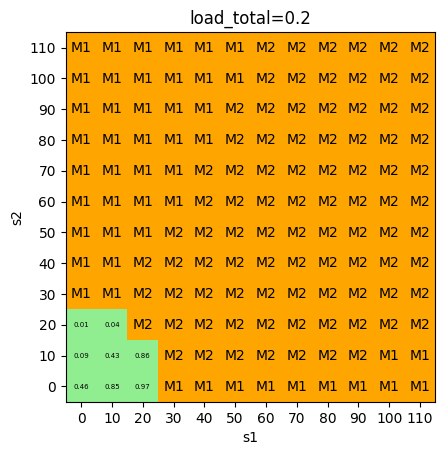

state: tensor([[0., 0., 1.]]) dist_dsc.probs: tensor([[0.0062, 0.0057, 0.0057, 0.9825]], grad_fn=<DivBackward0>) dist_cnt.mean: tensor([[0.0187]], grad_fn=<TanhBackward0>) dist_cnt.scale tensor([[1.2399]], grad_fn=<ExpBackward0>)
3 0.018713234
0.018713234 <class 'numpy.ndarray'>
state: tensor([[ 0., 10.,  1.]]) dist_dsc.probs: tensor([[0.0189, 0.0306, 0.0306, 0.9200]], grad_fn=<DivBackward0>) dist_cnt.mean: tensor([[-0.8284]], grad_fn=<TanhBackward0>) dist_cnt.scale tensor([[1.5557]], grad_fn=<ExpBackward0>)
3 -0.82841563
-0.82841563 <class 'numpy.ndarray'>
state: tensor([[ 0., 20.,  1.]]) dist_dsc.probs: tensor([[0.0519, 0.1654, 0.1644, 0.6183]], grad_fn=<DivBackward0>) dist_cnt.mean: tensor([[-0.9827]], grad_fn=<TanhBackward0>) dist_cnt.scale tensor([[2.2401]], grad_fn=<ExpBackward0>)
3 -0.98265386
-0.98265386 <class 'numpy.ndarray'>
state: tensor([[ 0., 30.,  1.]]) dist_dsc.probs: tensor([[0.0611, 0.3830, 0.3790, 0.1769]], grad_fn=<DivBackward0>) dist_cnt.mean: tensor([[-0.9984]], g

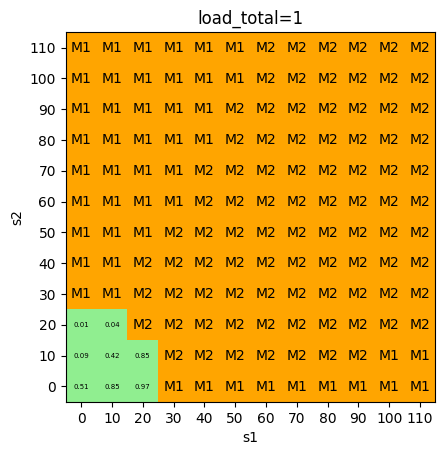

state: tensor([[0.0000, 0.0000, 1.8000]]) dist_dsc.probs: tensor([[0.0076, 0.0078, 0.0078, 0.9768]], grad_fn=<DivBackward0>) dist_cnt.mean: tensor([[0.0477]], grad_fn=<TanhBackward0>) dist_cnt.scale tensor([[1.3071]], grad_fn=<ExpBackward0>)
3 0.047661725
0.047661725 <class 'numpy.ndarray'>
state: tensor([[ 0.0000, 10.0000,  1.8000]]) dist_dsc.probs: tensor([[0.0209, 0.0358, 0.0357, 0.9076]], grad_fn=<DivBackward0>) dist_cnt.mean: tensor([[-0.8315]], grad_fn=<TanhBackward0>) dist_cnt.scale tensor([[1.4991]], grad_fn=<ExpBackward0>)
3 -0.8314953
-0.8314953 <class 'numpy.ndarray'>
state: tensor([[ 0.0000, 20.0000,  1.8000]]) dist_dsc.probs: tensor([[0.0544, 0.1828, 0.1816, 0.5812]], grad_fn=<DivBackward0>) dist_cnt.mean: tensor([[-0.9830]], grad_fn=<TanhBackward0>) dist_cnt.scale tensor([[2.1582]], grad_fn=<ExpBackward0>)
3 -0.982999
-0.982999 <class 'numpy.ndarray'>
state: tensor([[ 0.0000, 30.0000,  1.8000]]) dist_dsc.probs: tensor([[0.0598, 0.3941, 0.3900, 0.1561]], grad_fn=<DivBackwa

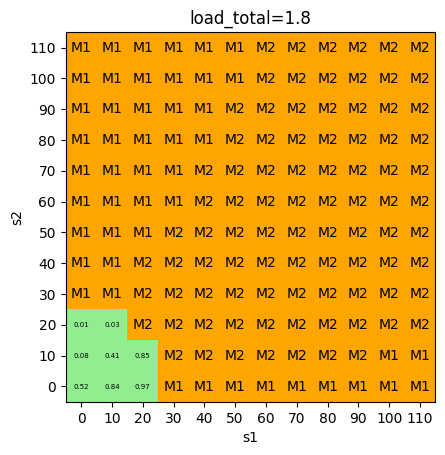

state: tensor([[0., 0., 1.]]) dist_dsc.probs: tensor([[0.0062, 0.0057, 0.0057, 0.9825]], grad_fn=<DivBackward0>) dist_cnt.mean: tensor([[0.0187]], grad_fn=<TanhBackward0>) dist_cnt.scale tensor([[1.2399]], grad_fn=<ExpBackward0>)
state: tensor([[ 0., 10.,  1.]]) dist_dsc.probs: tensor([[0.0189, 0.0306, 0.0306, 0.9200]], grad_fn=<DivBackward0>) dist_cnt.mean: tensor([[-0.8284]], grad_fn=<TanhBackward0>) dist_cnt.scale tensor([[1.5557]], grad_fn=<ExpBackward0>)
state: tensor([[ 0., 20.,  1.]]) dist_dsc.probs: tensor([[0.0519, 0.1654, 0.1644, 0.6183]], grad_fn=<DivBackward0>) dist_cnt.mean: tensor([[-0.9827]], grad_fn=<TanhBackward0>) dist_cnt.scale tensor([[2.2401]], grad_fn=<ExpBackward0>)
state: tensor([[ 0., 30.,  1.]]) dist_dsc.probs: tensor([[0.0611, 0.3830, 0.3790, 0.1769]], grad_fn=<DivBackward0>) dist_cnt.mean: tensor([[-0.9984]], grad_fn=<TanhBackward0>) dist_cnt.scale tensor([[3.2241]], grad_fn=<ExpBackward0>)
state: tensor([[ 0., 40.,  1.]]) dist_dsc.probs: tensor([[0.0381, 0.

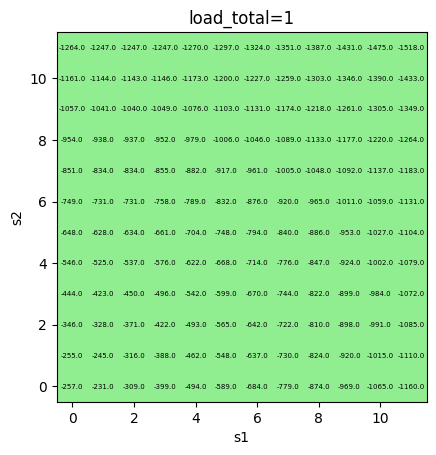

[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
[16698, 16070]


In [15]:
def one_hot_encoding(levels, n_units=2,n_states=5, MAX_maintenance_time=0):
    level_ohe = []
    #mstatus_ohe = []
    for unit_idx in range(n_units):
        l = [0] * n_states
        #m = [0] * (MAX_maintenance_time + 1)
        l[levels[unit_idx]] = 1
        #m[maintenance_status[unit_idx]] = 1
        level_ohe = level_ohe + l
        #mstatus_ohe = mstatus_ohe + m
    return level_ohe #, mstatus_ohe


def get_color(action):
    if action < 0:
        print(action)
        return "white"
    #cmap = ["red","sandybrown","orange","lawngreen","darkorange","lightgreen","green","lightblue"]
    cmap = ["red","orange","orange","lightgreen","orange","lightgreen","lightgreen","lightblue"]
    return cmap[action]

def plot_action(ax, center_x, center_y, act_dsc, act_cnt, load_total):
    size = 1
    opt_action = patches.Rectangle(
        (center_x-size/2, center_y-size/2),
        1,
        1,
        linewidth = 0,
        facecolor = get_color(act_dsc)
    )
    ax.add_patch(opt_action)
    #print(act_dsc)
    if act_dsc==0:
        ax.text(center_x,center_y,f'M12',ha='center', va='center')
    elif act_dsc==1:
        ax.text(center_x,center_y,f'M1',ha='center', va='center')
    elif act_dsc==2:
        ax.text(center_x,center_y,f'M2',ha='center', va='center')
    else: #稼働継続
        print(act_cnt, type(act_cnt))
        act_cnt = act_cnt * 0.5 + 0.5
        #ax.text(center_x, center_y,f'{(round(act_cnt[0],2),round(1-act_cnt[0],2))}',ha='center', va='center',fontsize=5)
        ax.text(center_x, center_y, f'{(round(act_cnt, 2))}', ha='center', va='center', fontsize=5)

def plot_state_value(ax, center_x, center_y, val):
    size = 1
    opt_action = patches.Rectangle(
        (center_x-size/2, center_y-size/2),
        1,
        1,
        linewidth = 0,
        facecolor = get_color(act_dsc)
    )
    ax.add_patch(opt_action)
    #print(act_dsc)

    ax.text(center_x, center_y, f'{round(float(val), 0)}', ha='center', va='center', fontsize=5)


def optimal_policy(load_total):
    fig, ax = plt.subplots()
    x = 10
    for s1 in range(x+2):
        for s2 in range(x+2):
            a =env.L/(x)
            x1 =s1*a
            x2 =s2*a
            #level_ohe = one_hot_encoding(levels=[s2,s3])
            state = [x1,x2] + list([load_total])
            #print(state)
            act_dsc, act_cnt, log_prob_dsc, log_prob_cnt, val = agent.choose_action_max_prob(state)
            act_dsc = act_dsc.item()
            act_cnt = act_cnt.squeeze().cpu().detach().numpy().copy()
            print(act_dsc,act_cnt)
            #print("val:",val)

            plot_action(ax, s1, s2, act_dsc, act_cnt, load_total)
    ax.set_xlim(-0.5,x+1.5)
    ax.set_ylim(-0.5,x+1.5)
    #cbar = plt.colorbar(scatter, cax=cax, ticks=np.arange(0.5, 8.5, 1))
    #cbar.ax.set_yticklabels([f'{i:b}' for i in range(8)])
    ax.set_aspect('equal', adjustable='box')  # アスペクト比を保持
    ax.set_xlabel("s1") #変更
    ax.set_ylabel("s2") #変更
    # グラフを表示
    ax.set_title("load_total="+str(load_total))

    # 軸のラベルを設定
    ax.set_xticks(range(x+2))  # 目盛りの位置を設定
    ax.set_xticklabels([f"{int(label * a)}" for label in ax.get_xticks()])  # X倍の値でラベルを整数で更新
    ax.set_yticks(range(x+2))
    ax.set_yticklabels([f"{int(label * a)}" for label in ax.get_yticks()])
    plt.show()

def state_value(load_total):
    fig, ax = plt.subplots()
    x = 10
    for s1 in range(x+2):
        for s2 in range(x+2):
            a =env.L/(x)
            x1 =s1*a
            x2 =s2*a
            #level_ohe = one_hot_encoding(levels=[s2,s3])
            state = [x1,x2] + list([load_total])
            act_dsc, act_cnt, log_prob_dsc, log_prob_cnt, val = agent.choose_action_max_prob(state)
            act_dsc = act_dsc.item()
            act_cnt = act_cnt.squeeze().cpu().detach().numpy().copy()
            #print(act_dsc,act_cnt)
            #print("val:",val)
            #status = np.array([(cs1<env.failures[0])*1,(cs2<env.failures[1])*1,(cs3<env.failures[2])*1])
            plot_state_value(ax, s1, s2, val)
    # 軸の範囲と目盛りを設定
    ax.set_xlim(-0.5,x+1.5)
    ax.set_ylim(-0.5,x+1.5)
    #cbar = plt.colorbar(scatter, cax=cax, ticks=np.arange(0.5, 8.5, 1))
    #cbar.ax.set_yticklabels([f'{i:b}' for i in range(8)])
    ax.set_aspect('equal', adjustable='box')  # アスペクト比を保持
    ax.set_xlabel("s1") #変更
    ax.set_ylabel("s2") #変更
    # グラフを表示
    ax.set_title("load_total="+str(load_total))


    plt.show()

optimal_policy(load_total=0.2)
optimal_policy(load_total=1)
optimal_policy(load_total=1.8)

state_value(load_total=1)

#optimal_policy(s1=0,m1=0,m2=0,m3=0,b=1,d=0,t=1)
#optimal_policy(s1=1,m1=0,m2=0,m3=0,b=1,d=0,t=1)
#optimal_policy(s1=2,m1=0,m2=0,m3=0,b=1,d=0,t=1)
#optimal_policy(s1=3,m1=0,m2=0,m3=0,b=1,d=0,t=1)
#optimal_policy(s1=4,m1=0,m2=0,m3=0,b=1,d=0,t=1)
#optimal_policy(s1=4,m1=0,m2=0,m3=0,b=0,d=0,t=1)
#optimal_policy(s1=0,m1=1,m2=1,m3=0,b=1,d=0,t=1)
#optimal_policy(s1=0,m1=0,m2=0,m3=0,b=1,d=0,t=0.5)
#optimal_policy(s1=0,m1=0,m2=0,m3=0,b=-1,d=0,t=1)
#optimal_policy(s1=1,m1=0,m2=0,m3=0,b=-1,d=0,t=1)
#optimal_policy(s1=2,m1=0,m2=0,m3=0,b=-1,d=0,t=1)
#optimal_policy(s1=3,m1=0,m2=0,m3=0,b=-1,d=0,t=1)
#optimal_policy(s1=4,m1=0,m2=0,m3=0,b=-1,d=-1,t=0.3)
#optimal_policy(s1=0,m1=0,m2=0,m3=0,b=-1,d=-1,t=0.3)
#optimal_policy(s1=1,m1=0,m2=0,m3=0,b=-1,d=-1,t=0.3)
#optimal_policy(s1=2,m1=0,m2=0,m3=0,b=-1,d=-1,t=0.3)
#optimal_policy(s1=3,m1=0,m2=0,m3=0,b=-1,d=-1,t=0.3)
#optimal_policy(s1=4,m1=0,m2=0,m3=0,b=-1,d=-1,t=0.3)
s1 = 4
s2 = 4
s3 = 4
m1 = 0
m2 = 0
m3 = 0
inventory = 0
#demand = 0
remain_interval = 1
#level_ohe, mstatus_ohe = one_hot_encoding(levels=[s1,s2,s3],maintenance_status=[m1,m2,m3])
#state = level_ohe + mstatus_ohe + list([inventory,demand,remain_interval])
#act_dsc, act_cnt, log_prob, val = agent.choose_action_max_prob(state)
#act_dsc = act_dsc.item()
#act_dsc
print(env.Visit)
print(env.cntCount)

In [14]:
"""
def get_color(action):
    if action < 0:
        return "white"
    #cmap = ["red","sandybrown","orange","lawngreen","darkorange","lightgreen","green","blue"]
    cmap = ["red","orange","orange","lightgreen","orange","lightgreen","lightgreen","lightblue"]
    return cmap[action]

def plot_action(ax, center_x, center_y, size, action):
    opt_action = patches.Rectangle(
        (center_x-size/2, center_y-size/2),
        size,
        size,
        linewidth = 0,
        facecolor = get_color(action)
    )
    ax.add_patch(opt_action)
    if action >= 0:
        r = list(map(int, bin(action)[2:].zfill(env.num_targets)))
        #ax.text(center_x,center_y,f'({r[0]},{r[1]},{r[2]})',ha='center', va='center')
        ax.text(center_x,center_y,f'{action}',ha='center', va='center')

def optimal_policy(load_total):
    fig, ax = plt.subplots()
    x = 26
    for s1 in range(x):
        for s2 in range(x):
            state = [s1,s2] + list([load_total])
            act_dsc, act_cnt, log_prob_dsc, log_prob_cnt, val = agent.choose_action_max_prob(state)
            act_dsc = act_dsc.item()
            act_cnt = act_cnt.squeeze().cpu().detach().numpy().copy()
            #print(act_dsc,act_cnt)
            print("val:",val)
            #status = np.array([(cs1<env.failures[0])*1,(cs2<env.failures[1])*1,(cs3<env.failures[2])*1])
            plot_action(ax, s1, s2, act_dsc, act_cnt, load_total)
            plot_action(ax,cs2,cs3,size=1,action=action)
    ax.set_xlim(-0.5,x-1+0.5)
    ax.set_ylim(-0.5,x-1+0.5)
    #cbar = plt.colorbar(scatter, cax=cax, ticks=np.arange(0.5, 8.5, 1))
    #cbar.ax.set_yticklabels([f'{i:b}' for i in range(8)])
    ax.set_aspect('equal', adjustable='box')  # アスペクト比を保持
    ax.set_xlabel("s2")
    ax.set_ylabel("s3")
    # グラフを表示
    ax.set_title("(s1="+str(cs1)+", s2, s3, z1="+str(cz1)+", z2="+str(cz2)+", z3="+str(cz3)+")")
    plt.show()

optimal_policy(load_total=0.2)
optimal_policy(load_total=1)
optimal_policy(load_total=1.8)
"""

'\ndef get_color(action):\n    if action < 0:\n        return "white"\n    #cmap = ["red","sandybrown","orange","lawngreen","darkorange","lightgreen","green","blue"]\n    cmap = ["red","orange","orange","lightgreen","orange","lightgreen","lightgreen","lightblue"]\n    return cmap[action]\n\ndef plot_action(ax, center_x, center_y, size, action):\n    opt_action = patches.Rectangle(\n        (center_x-size/2, center_y-size/2),\n        size,\n        size,\n        linewidth = 0,\n        facecolor = get_color(action)\n    )\n    ax.add_patch(opt_action)\n    if action >= 0:\n        r = list(map(int, bin(action)[2:].zfill(env.num_targets)))\n        #ax.text(center_x,center_y,f\'({r[0]},{r[1]},{r[2]})\',ha=\'center\', va=\'center\')\n        ax.text(center_x,center_y,f\'{action}\',ha=\'center\', va=\'center\')\n\ndef optimal_policy(load_total):\n    fig, ax = plt.subplots()\n    x = 26\n    for s1 in range(x):\n        for s2 in range(x):\n            state = [s1,s2] + list([load_total]